<a href="https://colab.research.google.com/github/yqwang1/Computational_Neuro/blob/main/Allen_natural_images_sparse_dense_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To get the data, copy the file at https://drive.google.com/file/d/1jp1NRQuidfjRkwJUVd59pLmmzn8oPeC5/view?usp=sharing into your colab drive folder then run the next cell

In [ ]:
!unzip siegle_791319847.zip

In [ ]:
pip install rastermap

In [ ]:
import os
import warnings
import neurocode as nc
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from rastermap import Rastermap


In [ ]:
# load data
FileDir = r'.'
Experiment = ''

stims=nc.load_object(os.path.join(FileDir, Experiment, 'stims_natural_scenes'))
frame_plus_one = nc.load_object(os.path.join(FileDir, Experiment, 'frame_plus_one'))
clusters = nc.load_object(os.path.join(FileDir, Experiment, 'clusters'))



In [ ]:
# this cell will do some computations we use later

# frame_plus_one.spike_counts: size nFrames x nClusters x nRepeats
# Frame here means what stimulus was shown
# we use frame_plus_one because Allen use -1 to mean the blank frame

# frame_plus_one.train_mean: size nFrames x nClusters, mean over training repeats
# frame_plus_one.test_mean: size nFrames x nClusters, mean over test repeats
# frame_plus_one.all_mean: size nFrames x nClusters, mean over all repeats

# locs_nuff_cells: brain locations where we have at least 8 cells recorded

train = np.arange(0,25)
test = np.arange(25,50)

nStims = len(stims)
nClusters = len(clusters)
nFrames = len(frame_plus_one)
nRepeats = 50

frame_plus_one.spike_counts = np.histogramdd([stims.frame.repeat(nClusters)+1, np.tile(np.arange(nClusters),nStims),
                                              stims.repeat.repeat(nClusters)],
                    bins=[np.arange(nFrames+1), np.arange(nClusters+1), np.arange(nRepeats+1)],
                    weights=stims.spike_counts.ravel()
                  )[0]

# make mean spike counts for training and test sets

frame_plus_one.train_mean = frame_plus_one.spike_counts[:,:,train].mean(2)
frame_plus_one.test_mean = frame_plus_one.spike_counts[:,:,test].mean(2)
frame_plus_one.all_mean = frame_plus_one.spike_counts[:,:,:].mean(2)

# locs: string array containing names of brain locations
# clu_loc: location number of each cluster in this array
locs, clu_loc = np.unique(clusters.brainLocationAcronyms_ccf_2017, return_inverse=True)
locs_nCells = np.bincount(clu_loc) # number of cells in each location
locs_nuff_cells = locs[locs_nCells>=8]
for l in locs_nuff_cells:
  print(f'{l}: {np.sum(clusters.brainLocationAcronyms_ccf_2017==l)} cells')

In [ ]:
# show stimuli
images = np.load('All_images.npy')
im0 = images[0,:,:]
fig, ax = plt.subplots(7,17,figsize=(34*1.174,14*.918), sharex=True, sharey=True, gridspec_kw={'wspace':.05, 'hspace':.05})
for i in np.arange(-1,118):
    plt.sca(ax.flat[i+1])
    if i==-1:
        plt.imshow(128*np.ones_like(im0), cmap='gray',vmin=0,vmax=255)
    else:
        im = images[i,:,:]
        plt.imshow(im, cmap='gray',vmin=0,vmax=255)
    plt.axis('off')

In [ ]:
# visualize the mean responses of all cells to all stimuli with Rastermap
# separately for each area
import warnings

# normalize firing rates by each cell's mean rate
train_norm = frame_plus_one.train_mean / frame_plus_one.train_mean.mean(0,keepdims=True)
test_norm = frame_plus_one.test_mean / frame_plus_one.test_mean.mean(0,keepdims=True)

for l in locs_nuff_cells:

  plt.figure()
  my_cells = (clusters.brainLocationAcronyms_ccf_2017==l)
  my_train = train_norm[:,my_cells]
  my_test = test_norm[:,my_cells]

  with warnings.catch_warnings(action="ignore"):
    model = Rastermap().fit(my_train) # sort so correlated stimuli are close
    frame_sort = model.isort
    model2 = Rastermap().fit(model.X_embedding.T) # sort so correlated cells are close
    cell_sort = model2.isort

  plt.imshow(my_test[np.ix_(frame_sort, cell_sort)].T, vmin=0, vmax=3, cmap="gray_r")
  #plt.colorbar()
  plt.ylabel('Cell')
  plt.xlabel('Stimulus')
  plt.title(l)
  plt.show()

**EXERCISE**: do this again but without using separate repeats for sorting and visualization.  How does it look different to when you do it with a validation set?  What difference do you see in VISp? What difference do you see in CA1?

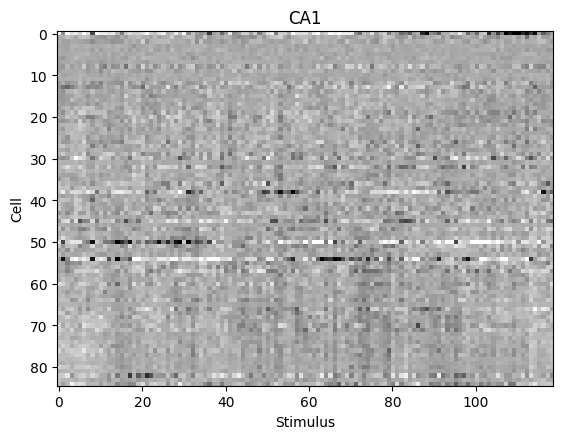

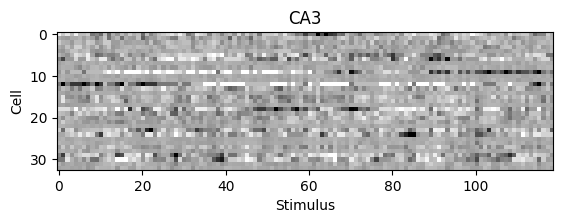

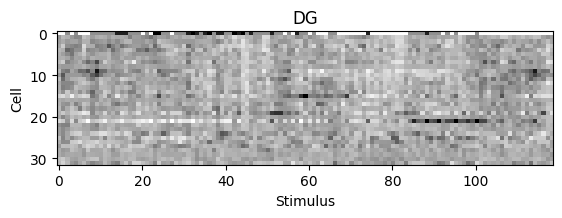

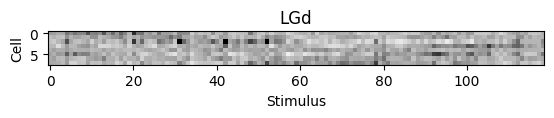

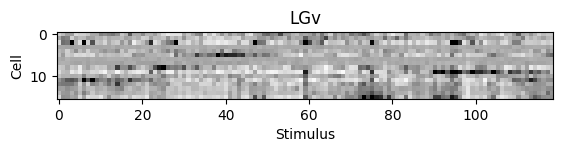

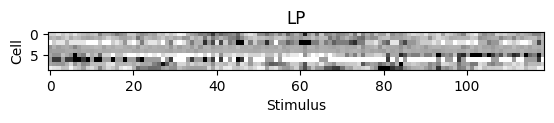

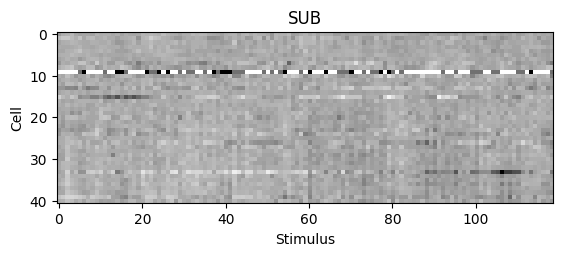

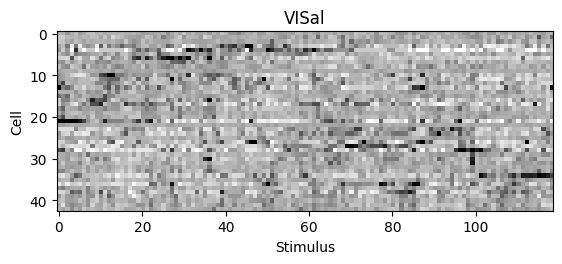

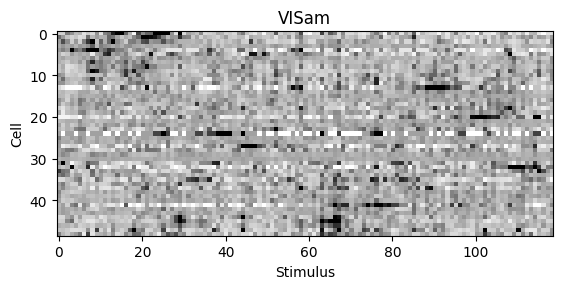

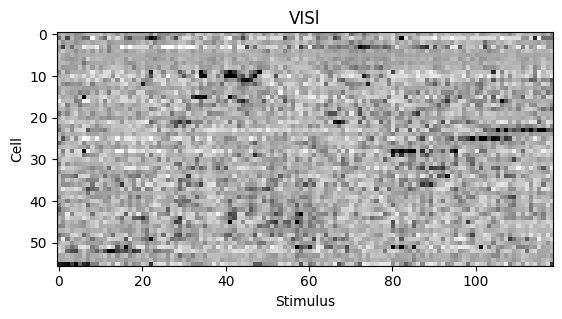

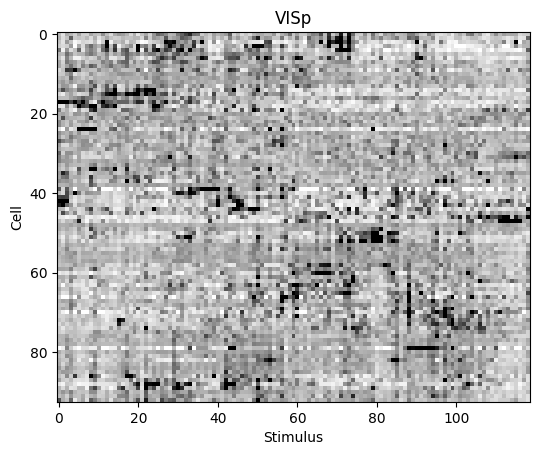

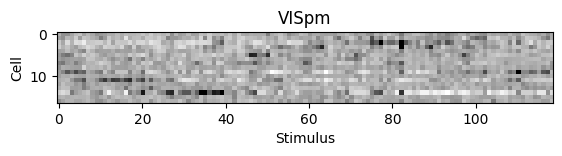

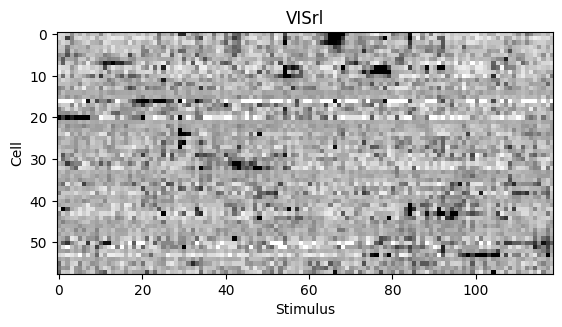

In [ ]:
# write code here. answer should look like below

EXERCISE: Compute the lifetime sparseness, lifetime kurtosis, and lifetime skewness for each cell.  Store them in arrays
`clusters.lifetime_sparseness`, `clusters.lifetime_kurtosis`, `clusters.lifetime_skewness`.

HINT: use the formula for lifetime sparseness in the lecture. Functions for `kurtosis` and `skew` are in `scipy.stats`, which we imported as `stats`.  Remember that functions for mean, kurtosis, skewness can be given an `axis=0` argument to average over frames

In [ ]:
# write code here

In [ ]:
# now we will plot them

grouped_lifetime_sparseness = [clusters.lifetime_sparseness[clusters.brainLocationAcronyms_ccf_2017==l]
           for l in locs_nuff_cells]
# plt.violinplot(grouped_stim_var);
# plt.gca().set_xticks(range(len(locs)))
# plt.gca().set_xticklabels(locs);

plt.figure(figsize=(5,5))
plt.boxplot(grouped_lifetime_sparseness, notch=True, sym='.', showmeans=True,
               meanprops={'markeredgewidth': 0, 'markerfacecolor': '#7F007F'});
plt.xticks(ticks=1+np.arange(len(locs_nuff_cells)),labels=locs_nuff_cells, rotation=90);
plt.ylabel('Lifetime sparseness')


**EXERCISE**: make a similar plot for kurtosis and skew

Text(0, 0.5, 'Lifetime skewness')

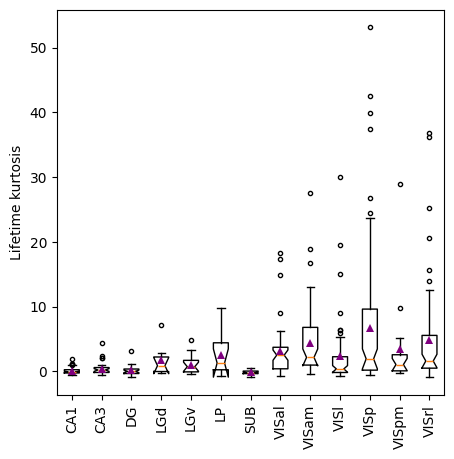

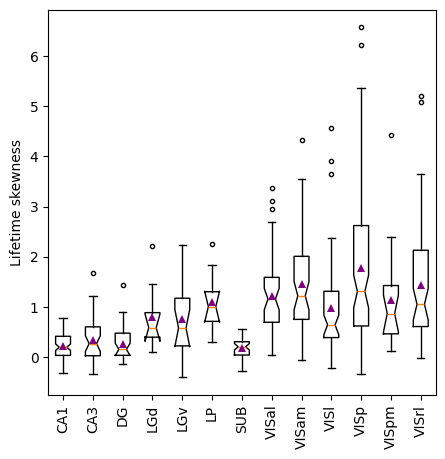

In [ ]:
# write code here. should look like below

In [ ]:
# information theory: compute bits/trial
clusters.bits = np.zeros(nClusters)
for cv in range(5):
    test = np.arange(cv*10, (cv+1)*10)
    train = np.setdiff1d(np.arange(50),test)
    eps = .1

    train_mean = frame_plus_one.spike_counts[:,:,train].mean(2,keepdims=True) + eps
    grand_mean = frame_plus_one.spike_counts[:,:,train].mean(2,keepdims=True).mean(0,keepdims=True) + eps

    clusters.bits += np.sum(frame_plus_one.spike_counts[:,:,test]*(np.log(train_mean)-np.log(grand_mean)) \
                             - (train_mean-grand_mean)
                            ,(0,2))/nFrames/10/np.log(2)/5

grouped = [clusters.bits[clusters.brainLocationAcronyms_ccf_2017==l] for l in locs_nuff_cells]

plt.figure(figsize=(5,5))
plt.boxplot(grouped, notch=True, sym='.', showmeans=True,
               meanprops={'markeredgewidth': 0, 'markerfacecolor': '#7F007F'});
plt.xticks(ticks=1+np.arange(len(locs_nuff_cells)),labels=locs_nuff_cells, rotation=90);
plt.ylabel('bits/trial')
plt.grid(True)
#np.argmax(bits)
plt.axhline(0)

In [ ]:
# to get bits/second, remember that the time-bin length of each trial is 210ms (40 to 250 ms)

time_bin_len = .21
grouped = [clusters.bits[clusters.brainLocationAcronyms_ccf_2017==l]/time_bin_len \
           for l in locs_nuff_cells]

plt.figure(figsize=(5,5))
plt.boxplot(grouped, notch=True, sym='.', showmeans=True,
               meanprops={'markeredgewidth': 0, 'markerfacecolor': '#7F007F'});
plt.xticks(ticks=1+np.arange(len(locs_nuff_cells)),labels=locs_nuff_cells, rotation=90);
plt.ylabel('bits/sec')
plt.grid(True)
#np.argmax(bits)
plt.axhline(0)


In [ ]:
# to get bits/spike, divide by each cell's mean firing rate over trials and stimuli
mean_spkcnt = frame_plus_one.spike_counts.mean(axis=(0,2))

grouped = [(clusters.bits/mean_spkcnt)[clusters.brainLocationAcronyms_ccf_2017==l] \
           for l in locs_nuff_cells]

plt.figure(figsize=(5,5))
plt.boxplot(grouped, notch=True, sym='.', showmeans=True,
               meanprops={'markeredgewidth': 0, 'markerfacecolor': '#7F007F'});
plt.xticks(ticks=1+np.arange(len(locs_nuff_cells)),labels=locs_nuff_cells, rotation=90);
plt.ylabel('bits/spike')
plt.grid(True)
#np.argmax(bits)
plt.axhline(0)

**QUESTION**: Go back and look at the cross-validated rasters for LGv and VISp.  Which one looks like a sparser code?  